In [23]:
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt

file_one = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/annotated-batches/khbatch79/D3C1217-200544F010-0_8.png'
file_two = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/annotated-batches/threshold/D3C1210-100092A001-0_8-cloud-mask.png'

arr_one = np.array(Image.open(file_one).convert('L'))
arr_two = np.array(Image.open(file_two).convert('L'))

print(arr_one.min(), arr_one.max())
print(list(set(arr_one.flatten())))

print(arr_two.min(), arr_two.max())
print(list(set(arr_two.flatten())))

zero_255 = np.sum(arr_two==0) + np.sum(arr_two==255)
non_0_255 = arr_two.shape[0]**2-zero_255

print(non_0_255 / (zero_255 + non_0_255) * 100)

0 1
[0, 1]
0 255
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 52, 56, 60, 62, 63, 64, 65, 66, 68, 72, 75, 77, 80, 81, 83, 84, 85, 86, 87, 88, 90, 91, 95, 96, 98, 99, 100, 102, 103, 104, 105, 108, 110, 112, 116, 117, 124, 128, 129, 141, 143, 151, 154, 155, 157, 159, 164, 166, 168, 172, 173, 175, 179, 180, 181, 182, 186, 191, 192, 193, 194, 195, 197, 204, 207, 209, 221, 222, 223, 229, 233, 239, 244, 255]
0.016737196180555556


In [26]:
import os 

directory = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/annotated-batches'

count = 0
for sub_dir in os.listdir(directory):
    if 'khbatch' in sub_dir and '.' not in sub_dir: 
        sub_dir = os.path.join(directory, sub_dir)
        for file in os.listdir(sub_dir): 
            if '.png' in file: 
                count+=1

print(count)

2037


In [27]:
80*28

2240

## Update Catalogue CSV with Area Calculation

In [35]:
import pandas as pd 
from shapely.geometry import Polygon
from pyproj import Geod
import numpy as np

def calculate_area_shapely(corners):
    """
    Calculate the area of a polygon (quadrilateral) using Shapely and Pyproj for geodesic calculations.

    Parameters:
    corners (list of tuples): List of four (latitude, longitude) tuples.

    Returns:
    float: Area in square kilometers.
    """
    try:
        # Ensure the polygon is closed by appending the first corner to the end
        if corners[0] != corners[-1]:
            corners.append(corners[0])

        corners = [(round(lat, 6), round(lon, 6)) for lat, lon in corners]

        polygon = Polygon(corners)

        # Check if the polygon is valid
        if not polygon.is_valid or polygon.is_empty:
            print("Invalid polygon detected:", corners)
            return np.nan  # Skip invalid polygons

        # Ensure correct winding order (counterclockwise)
        if not polygon.exterior.is_ccw:
            corners = corners[::-1]  # Reverse order to counterclockwise
            polygon = Polygon(corners)

        # Use geodesic area calculation with Pyproj
        geod = Geod(ellps="WGS84")
        area_m2 = abs(geod.geometry_area_perimeter(polygon)[0])  # Get area in square meters

        print(f"Calculated area (m²): {area_m2}")

        return area_m2 / 1e6  # Convert square meters to square kilometers

    except Exception as e:
        print(f"Error processing polygon {corners}: {e}")
        return np.nan  # Return NaN in case of errors

def calculate_area_aea(corners):
    from functools import partial
    from shapely.geometry import Polygon
    import pyproj

    corners = [(lon, lat) for lat, lon in corners]

    input_geometry = Polygon(corners)

    # Define projection transformation to Albers Equal Area (AEA)
    proj = partial(
        pyproj.transform,
        pyproj.CRS.from_epsg(4326),  
        pyproj.Proj(proj='aea', lat_1=input_geometry.bounds[1], lat_2=input_geometry.bounds[3])
    )

    # Transform the polygon to the new coordinate system
    transformer = pyproj.Transformer.from_crs(pyproj.CRS.from_epsg(4326), 
        pyproj.CRS.from_proj4(f"+proj=aea +lat_1={input_geometry.bounds[1]} +lat_2={input_geometry.bounds[3]}"),
        always_xy=True
    )

    transformed_geom = transform(transformer.transform, input_geometry)

    area_m2 = transformed_geom.area
    area_km2 = area_m2 / 1e6  

    return area_km2



'''

If regional accuracy is required (e.g., within a continent), the Albers Equal Area (AEA) projection is preferred.
If global consistency is needed, the Equal Earth projection (EPSG:6933) is a better choice.

'''

def calculate_area_equal_earth(corners):
    from shapely.geometry import Polygon
    from shapely.ops import transform
    import pyproj

    corners = [(lon, lat) for lat, lon in corners]

    input_geometry = Polygon(corners)

    if not input_geometry.is_valid or input_geometry.is_empty:
        print("Invalid polygon detected:", corners)
        return None

    # Define projection transformation to Equal Earth (EPSG:6933)
    source_crs = pyproj.CRS.from_epsg(4326)  # WGS84 (latitude/longitude)
    target_crs = pyproj.CRS.from_epsg(6933)  # Equal Earth projection

    # Create transformer object to convert coordinates
    transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

    # Transform the polygon to the new coordinate system
    transformed_geom = transform(transformer.transform, input_geometry)

    area_m2 = transformed_geom.area
    area_km2 = area_m2 / 1e6  # Convert square meters to square kilometers

    return area_km2

csv_path = '/Users/tkiker/Documents/GitHub/khcloudnet/data/sampled_rows.csv'

df = pd.read_csv(csv_path)

df['area_kmsq_equal_area'] = df.apply(lambda row: calculate_area_equal_earth([
    (row['NW Corner Lat dec'], row['NW Corner Long dec']),
    (row['NE Corner Lat dec'], row['NE Corner Long dec']),
    (row['SE Corner Lat dec'], row['SE Corner Long dec']),
    (row['SW Corner Lat dec'], row['SW Corner Long dec']),
    (row['NW Corner Lat dec'], row['NW Corner Long dec'])  # Repeating first point
]), axis=1)

df['area_aea_kmsq'] = df.apply(lambda row: calculate_area_aea([
    (row['NW Corner Lat dec'], row['NW Corner Long dec']),
    (row['NE Corner Lat dec'], row['NE Corner Long dec']),
    (row['SE Corner Lat dec'], row['SE Corner Long dec']),
    (row['SW Corner Lat dec'], row['SW Corner Long dec']),
    (row['NW Corner Lat dec'], row['NW Corner Long dec'])  # Repeating first point
]), axis=1)


df.to_csv(csv_path, index=False)

df

,Entity ID,Acquisition Date,Mission,Camera,Camera Resolution,Operations Number,Center Latitude dec,Center Longitude dec,NW Corner Lat dec,NW Corner Long dec,NE Corner Lat dec,NE Corner Long dec,SE Corner Lat dec,SE Corner Long dec,SW Corner Lat dec,SW Corner Long dec,area_kmsq,area_aea_kmsq,area_kmsq_equal_area
0,D3C1215-300729F018,1979/06/13,1215-3,F,2 to 4 feet,729,38.702,59.077,38.894,58.297,38.725,59.788,38.487,59.788,38.726,58.272,1960.598629,2969.629441,2972.383126
1,D3C1218-100389F007,1983/08/24,1218-1,F,2 to 4 feet,389,49.198,43.216,49.601,40.887,49.022,45.618,48.789,45.605,49.379,40.767,10152.969285,9086.120017,9138.726861
2,D3C1217-200554F005,1982/07/04,1217-2,F,2 to 4 feet,554,62.335,171.388,62.536,170.492,62.301,172.448,62.140,172.358,62.352,170.355,NaN,2117.116042,2118.354496
3,D3C1216-100114F003,1980/07/01,1216-1,F,2 to 4 feet,114,43.659,58.446,43.822,57.871,43.663,59.105,43.504,59.067,43.640,57.804,1435.690020,1976.458458,1977.076701
4,D3C1210-200356F003,1975/07/29,1210-2,F,2 to 4 feet,356,43.704,-71.621,43.946,-72.794,43.629,-70.245,43.474,-70.272,43.737,-72.892,1910.091318,4366.817823,4373.862285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,D3C1217-200708F007,1982/07/18,1217-2,F,2 to 4 feet,708,59.031,14.860,59.221,14.052,59.009,15.808,58.849,15.735,59.038,13.937,3853.687038,2068.619880,2069.707066
9996,D3C1216-300804A022,1980/09/27,1216-3,A,2 to 4 feet,804,36.941,111.802,37.148,110.684,36.915,112.951,36.736,112.896,36.962,110.681,NaN,4114.170458,4108.842082
9997,D3C1216-200366A005,1980/08/02,1216-2,A,2 to 4 feet,366,46.122,2.946,46.350,1.657,46.076,4.278,45.897,4.208,46.163,1.649,5955.891143,4169.960270,4162.334137
9998,D3C1212-100029F022,1976/07/13,1212-1,F,2 to 4 feet,29,61.363,32.255,61.732,30.270,61.212,34.115,60.990,34.052,61.580,30.167,8008.784176,4563.487165,4587.433378


In [29]:
from functools import partial
from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj

row_corners = [
    (62.536, 170.492),
    (62.301, 172.448),
    (62.14, 172.358),
    (62.352, 170.355),
    (62.536, 170.492) 
]

row_corners_lonlat = [(lon, lat) for lat, lon in row_corners]

input_geometry = Polygon(row_corners_lonlat)

# Define projection transformation to Albers Equal Area (AEA)
proj = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),  # Source coordinate system (WGS84)
    pyproj.Proj(proj='aea', lat_1=input_geometry.bounds[1], lat_2=input_geometry.bounds[3])  # Albers projection
)

# Transform the polygon to the new coordinate system
transformed_geom = transform(proj, input_geometry)

area_m2 = transformed_geom.area
area_km2 = area_m2 / 1e6  # Convert area to square kilometers

# Print the results
print(f"Projected area (m²): {area_m2}")
print(f"Projected area (km²): {area_km2}")

Projected area (m²): 2117116042.2539496
Projected area (km²): 2117.1160422539497


/opt/homebrew/Caskroom/miniconda/base/envs/gsfc311/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/homebrew/Caskroom/miniconda/base/envs/gsfc311/lib/python3.11/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


Polygon area (Shapely): 0.3668310000000088


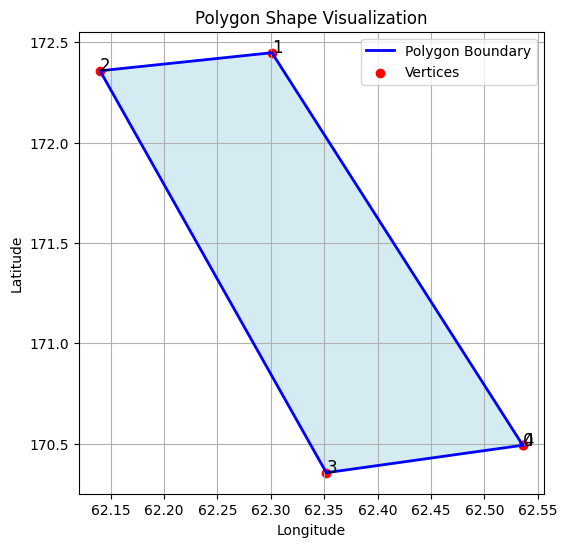

In [25]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Coordinates of the polygon (including the repeated first point to close the polygon)
row_corners = [
    (62.536, 170.492),
    (62.301, 172.448),
    (62.14, 172.358),
    (62.352, 170.355),
    (62.536, 170.492)  # Closing the polygon
]

polygon = Polygon(row_corners)

print("Polygon area (Shapely):", polygon.area)

x, y = polygon.exterior.xy

plt.figure(figsize=(6, 6))
plt.plot(x, y, 'b-', linewidth=2, label="Polygon Boundary")
plt.fill(x, y, color='lightblue', alpha=0.5)  
plt.scatter(x, y, color='red', label="Vertices")  

for i, (lon, lat) in enumerate(row_corners):
    plt.text(lon, lat, f'{i}', fontsize=12, color='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Polygon Shape Visualization')
plt.legend()
plt.grid()
plt.show()


In [28]:
from functools import partial 
from shapely import wkt, geometry, ops
import pyproj

proj = partial(pyproj.transform,
                pyproj.Proj(init='epsg:4326'),
                pyproj.Proj(proj='aea', lat1=input_geometry.bounds[1], lat2=input_geometry.bounds[3])
                )
transformed_geom = ops.transform(proj, input_geometry)
transformed_geom.area

nan

In [24]:
def is_collinear(corners):
    p1, p2, p3 = corners[:3]
    determinant = (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])
    return abs(determinant) < 1e-6  # Threshold for collinearity

print("Polygon is collinear:", is_collinear(row_corners))


Polygon is collinear: False


## cutout image work

In [38]:
from PIL import Image

cutout_image_path = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/strips/D3C1201-100006F001.jpg'
cutout_image = Image.open(cutout_image_path)
area_factor = cutouts_per_strip*cutout_image.height/cutout_image.width

cutouts_per_strip = 4



1920 29520


0.2601626016260163

## duplicates

In [39]:
import os
from collections import defaultdict

def find_duplicate_files(base_directory):

    file_locations = defaultdict(list)

    for root, _, files in os.walk(base_directory):
        for file in files:
            file_locations[file].append(root)

    # Find files that appear in more than one folder
    duplicate_files = {file: locations for file, locations in file_locations.items() if len(locations) > 1}

    return duplicate_files

base_dir = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/zipped-batches'  # Replace with your folder path
duplicates = find_duplicate_files(base_dir)

if duplicates:
    print("Duplicate files found in multiple folders:")
    for file, locations in duplicates.items():
        print(f"{file} found in:")
        for location in locations:
            print(f"  - {location}")
else:
    print("No duplicate files found across folders.")


No duplicate files found across folders.


### Find Missing in Batch 80

In [54]:
import os 
import numpy as np 

batch66_img_dir = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/zipped-batches/batch_66'
batch80_img_dir = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/zipped-batches/batch_80'
batch80_mask_dir = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/annotated-batches/khbatch80'

missing = [i for i in np.setxor1d(os.listdir(batch80_img_dir), os.listdir(batch80_mask_dir)) if 'DS_Store' not in i]
print(len(missing))

for file in os.listdir(batch80_img_dir):
    if file not in os.listdir(batch80_mask_dir): 
        print(file)

# switching batch 66 and batch 80???

#print(missing)

0
.DS_Store


## fix weird image

In [56]:
from PIL import Image

mask_image_path = '/Volumes/My Passport for Mac/khdata/khcloudnet/cloudnet-batch0/annotated-batches/khbatch63/D3C1214-300719F004-0_3.png'

try:
    img = Image.open(mask_image_path)
    img.load()  # Force loading to detect issues
    img.save(mask_image_path)  # Overwrite the file with a clean version
    print("Image re-saved successfully.")
except Exception as e:
    print(f"Failed to re-save image: {e}")


Failed to re-save image: image file is truncated


In [57]:
import os

file_size = os.path.getsize(mask_image_path)
if file_size == 0:
    print("The image file is empty.")
else:
    print(f"File size: {file_size} bytes")


File size: 3015237 bytes


## country code

In [58]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

def get_country_code(lat, lon):
    geolocator = Nominatim(user_agent="geo_locator")
    
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        if location and 'country_code' in location.raw['address']:
            return location.raw['address']['country_code'].upper()
        else:
            return "N/A"
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"Error with geolocation service: {e}")
        return "N/A"

# Example usage
latitude = 37.7749
longitude = -122.4194
print(get_country_code(latitude, longitude))  # Expected output: 'US' (for San Francisco)

US


## resolution of low resolution dataset